In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 115

ng =4

ng_refs = (/ 4 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 1100

data w_diffuse
     &     /1.66 , 1.66 , 1.7 , 1.8/

data wgt
     &     /0.3 , 0.45 , 0.6 , 0.95/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

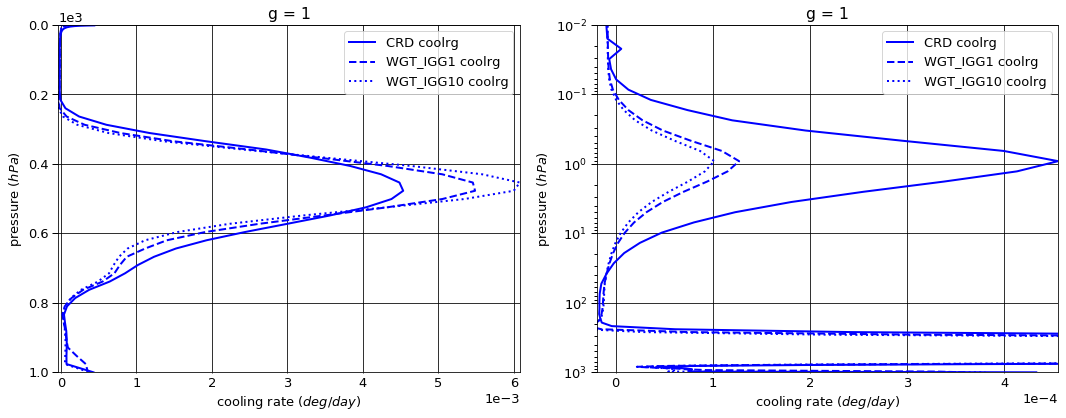

# Figure: cooling rate g-group 2

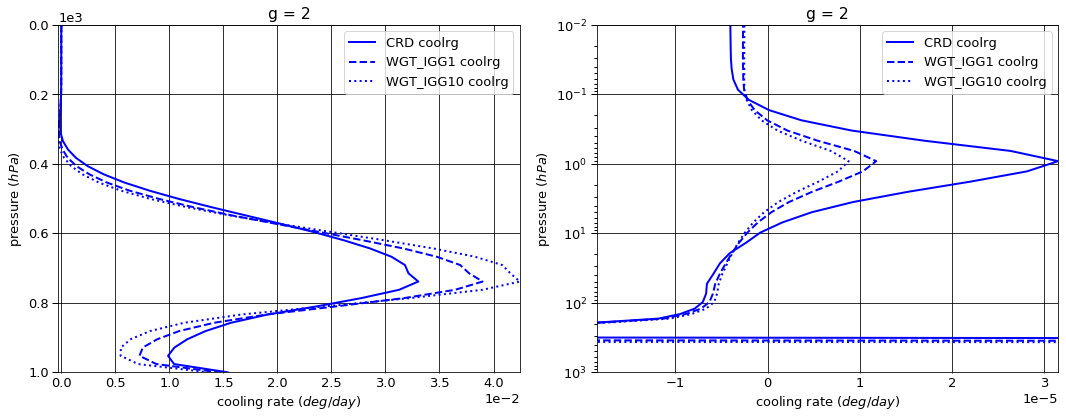

# Figure: cooling rate g-group 3

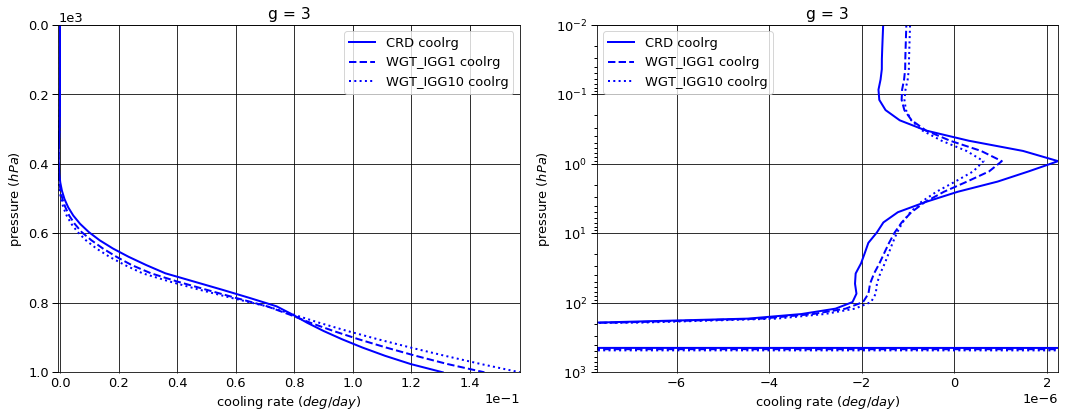

# Figure: cooling rate g-group 4

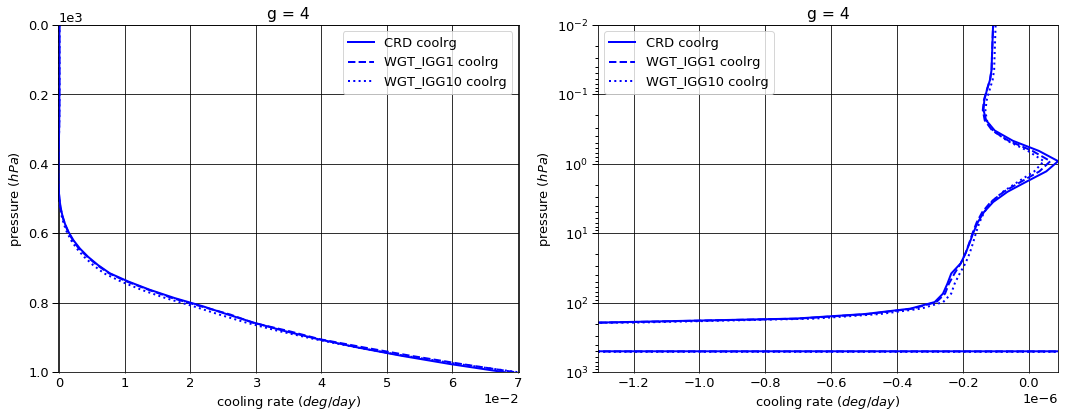

# Figure: cooling rate g-group total

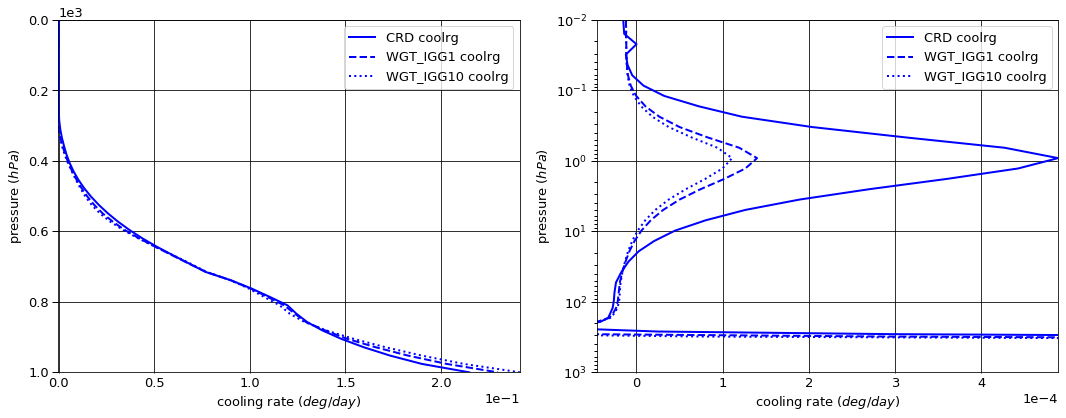

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.151234  0.000000  -0.151234
  1013.0   76     -0.396605  0.395457  -0.001148
2 0.0      1      -1.435465  0.000000  -1.435465
  1013.0   76     -2.270998  2.183383  -0.087614
3 0.0      1      -8.158652  0.000000  -8.158652
  1013.0   76     -9.077325  4.298841  -4.778483
4 0.0      1     -14.066714  0.000000 -14.066714
  1013.0   76    -14.320278  1.504488 -12.815790


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.150635  0.000000  -0.150635
  1013.0   76     -0.396605  0.396098  -0.000506
2 0.0      1      -1.435079  0.000000  -1.435079
  1013.0   76     -2.270998  2.210335  -0.060663
3 0.0      1      -8.216211  0.000000  -8.216211
  1013.0   76     -9.077325  4.260280  -4.817045
4 0.0      1     -14.068906  0.000000 -14.068906
  1013.0   76    -14.320278  1.516187 -12.804091


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.149620  0.000000  -0.149620
  1013.0   76     -0.396605  0.395606  -0.000998
2 0.0      1      -1.430923  0.000000  -1.430923
  1013.0   76     -2.270998  2.217785  -0.053212
3 0.0      1      -8.239207  0.000000  -8.239207
  1013.0   76     -9.077325  4.333366  -4.743959
4 0.0      1     -14.083058  0.000000 -14.083058
  1013.0   76    -14.320278  1.462063 -12.858215


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.995500e-04  0.000000  0.000600
  1013.0   76     0.000000e+00  0.000641  0.000641
2 0.0      1      3.863000e-04  0.000000  0.000386
  1013.0   76     0.000000e+00  0.026952  0.026952
3 0.0      1     -5.755890e-02  0.000000 -0.057559
  1013.0   76     1.776357e-15 -0.038562 -0.038562
4 0.0      1     -2.192000e-03  0.000000 -0.002192
  1013.0   76     0.000000e+00  0.011699  0.011699


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.614110e-03  0.000000  0.001614
  1013.0   76     0.000000e+00  0.000149  0.000149
2 0.0      1      4.541700e-03  0.000000  0.004542
  1013.0   76     0.000000e+00  0.034402  0.034402
3 0.0      1     -8.055510e-02  0.000000 -0.080555
  1013.0   76     1.776357e-15  0.034525  0.034525
4 0.0      1     -1.634400e-02  0.000000 -0.016344
  1013.0   76     0.000000e+00 -0.042425 -0.042425

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.457909e-05
  1001.112500 75     4.327350e-04
2 0.000312    1     -4.064408e-06
  1001.112500 75     1.540216e-02
3 0.000312    1     -1.453803e-06
  1001.112500 75     1.307899e-01
4 0.000312    1     -9.978774e-08
  1001.112500 75     6.807342e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -9.366968e-06
  1001.112500 75     3.589158e-04
2 0.000312    1     -2.583821e-06
  1001.112500 75     1.455585e-02
3 0.000312    1     -9.739812e-07
  1001.112500 75     1.450170e-01
4 0.000312    1     -9.969168e-08
  1001.112500 75     6.971302e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -9.157624e-06
  1001.112500 75     3.803062e-04
2 0.000312    1     -2.413975e-06
  1001.112500 75     1.356424e-02
3 0.000312    1     -8.947274e-07
  1001.112500 75     1.571202e-01
4 0.000312    1     -9.263088e-08
  1001.112500 75     7.014373e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.212126e-06
  1001.112500 75    -7.381916e-05
2 0.000312    1      1.480587e-06
  1001.112500 75    -8.463050e-04
3 0.000312    1      4.798217e-07
  1001.112500 75     1.422708e-02
4 0.000312    1      9.606500e-11
  1001.112500 75     1.639600e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.421470e-06
  1001.112500 75    -5.242876e-05
2 0.000312    1      1.650433e-06
  1001.112500 75    -1.837916e-03
3 0.000312    1      5.590755e-07
  1001.112500 75     2.633033e-02
4 0.000312    1      7.156858e-09
  1001.112500 75     2.070310e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.812065,0.000000,-23.812065
1013.0,76,-26.065205,8.382169,-17.683036



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.870830,0.000000,-23.870830
1013.0,76,-26.065205,8.382899,-17.682305



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.902808,0.00000,-23.902808
1013.0,76,-26.065205,8.40882,-17.656384



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.058765,0.00000,-0.058765
1013.0,76,0.000000,0.00073,0.000730



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.090743,0.000000,-0.090743
1013.0,76,0.000000,0.026651,0.026651


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000020
1001.112500,75,0.214698



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.229645



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.241209



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000007
1001.112500,75,0.014947



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000008
1001.112500,75,0.026510


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015957,0.014906
2,0.089391,0.086202
3,0.357652,0.344282
4,0.537000,0.554611


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.089438e-22
2,7.380948e-24
3,5.000596e-25
4,3.773541e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.089438e-22,NaN,0.015957,0.014906,0.015957,0.014906,600.0
2,7.380948e-24,0.067750,0.089391,0.086202,0.105348,0.101108,600.0
3,5.000596e-25,0.067750,0.357652,0.344282,0.463000,0.445389,600.0
4,3.773541e-26,0.075462,0.537000,0.554611,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.375231e-22  5.731382e-24  41.442552  5.208113e-09
      2 0.000312     3.241860e-24  1.340509e-25  24.183801  1.060434e-10
      3 0.000312     1.365979e-25  8.965100e-27  15.236631  5.919138e-12
      4 0.000312     5.081369e-27  3.669640e-28  13.847050  3.352871e-13
2     1 0.000750     2.393528e-22  5.743238e-24  41.675577  2.113288e-09
      2 0.000750     3.267241e-24  1.344673e-25  24.297656  4.303758e-11
      3 0.000750     1.375493e-25  9.001080e-27  15.281426  2.400460e-12
      4 0.000750     5.121648e-27  3.686994e-28  13.891122  1.361180e-13
3     1 0.001052     2.430970e-22  5.765243e-24  42.165961  3.008149e-09
      2 0.001052     3.319177e-24  1.352681e-25  24.537766  6.128596e-11
      3 0.001052     1.394971e-25  9.072105e-27  15.376481  3.413158e-12
      4 0.001052     5.204375e-27  3.721002e-28  13.986487  1.939683e-13
4     1 0.001476     2.469388e-22  5.788231e-24  42.662213  4.284186e-09
      2 0.001476     3.372613e-24  1.360952e-25  24.781281  8.732101e-11
      3 0.001476     1.415001e-25  9.144877e-27  15.473159  4.855787e-12
      4 0.001476     5.289892e-27  3.755962e-28  14.083987  2.765808e-13
5     1 0.002070     2.508270e-22  5.812131e-24  43.155769  6.099939e-09
      2 0.002070     3.426855e-24  1.369418e-25  25.024180  1.243883e-10
      3 0.002070     1.435325e-25  9.218612e-27  15.569862  6.906713e-12
      4 0.002070     5.377116e-27  3.791538e-28  14.181889  3.943150e-13
6     1 0.002904     2.547603e-22  5.837232e-24  43.644033  8.685808e-09
      2 0.002904     3.481904e-24  1.378141e-25  25.265223  1.772084e-10
      3 0.002904     1.455941e-25  9.293563e-27  15.666124  9.824983e-12
      4 0.002904     5.466069e-27  3.827895e-28  14.279567  5.622564e-13
7     1 0.004074     2.587381e-22  5.863951e-24  44.123507  1.236764e-08
      2 0.004074     3.537772e-24  1.387218e-25  25.502644  2.524632e-10
      3 0.004074     1.476852e-25  9.370126e-27  15.761285  1.397673e-11
      4 0.004074     5.556788e-27  3.865289e-28  14.376128  8.017889e-13
8     1 0.005714     2.627619e-22  5.892892e-24  44.589642  1.760838e-08
      2 0.005714     3.594513e-24  1.396788e-25  25.734138  3.596569e-10
      3 0.005714     1.498077e-25  9.448916e-27  15.854481  1.988189e-11
      4 0.005714     5.649384e-27  3.904106e-28  14.470368  1.143367e-12
9     1 0.008015     2.668294e-22  5.924880e-24  45.035409  2.506953e-08
      2 0.008015     3.652134e-24  1.407041e-25  25.956119  5.123843e-10
      3 0.008015     1.519612e-25  9.530723e-27  15.944356  2.828310e-11
      4 0.008015     5.743884e-27  3.944856e-28  14.560441  1.630609e-12
10    1 0.011243     2.709402e-22  5.961095e-24  45.451418  3.569055e-08
      2 0.011243     3.710684e-24  1.418254e-25  26.163752  7.299805e-10
      3 0.011243     1.541474e-25  9.616728e-27  16.029085  4.023474e-11
      4 0.011243     5.840392e-27  3.988297e-28  14.643827  2.325628e-12
11    1 0.015771     2.750931e-22  6.003193e-24  45.824462  5.081089e-08
      2 0.015771     3.770222e-24  1.430813e-25  26.350200  1.040057e-09
      3 0.015771     1.563673e-25  9.708592e-27  16.106073  5.723981e-11
      4 0.015771     5.939019e-27  4.035494e-28  14.716956  3.317228e-12
12    1 0.022122     2.792867e-22  6.053497e-24  46.136423  7.233568e-08
      2 0.022122     3.830832e-24  1.445270e-25  26.505997  1.481964e-09
      3 0.022122     1.586231e-25  9.808673e-27  16.171715  8.143591e-11
      4 0.022122     6.039923e-27  4.087970e-28  14.774871  4.732095e-12
13    1 0.031031     2.835332e-22  6.115330e-24  46.364336  1.029846e-07
      2 0.031031     3.892832e-24  1.462428e-25  26.618968  2.112019e-09
      3 0.031031     1.609248e-25  9.920546e-27  16.221369  1.158748e-10
      4 0.031031     6.143650e-27  4.148002e-28  14.811107  6.751707e-12
14    1 0.043528     2.890125e-22  6.199960e-24  46.615214  1.472109e-07
      2 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
